In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torchvision.transforms import transforms
import numpy as np 
import matplotlib.pyplot as plt
import time

In [2]:
img = torch.randn(size=(50, 3, 28, 28))
conv_weight = torch.rand(size=(5, 3, 3, 3))
F.conv2d(img, conv_weight).shape

torch.Size([50, 5, 26, 26])

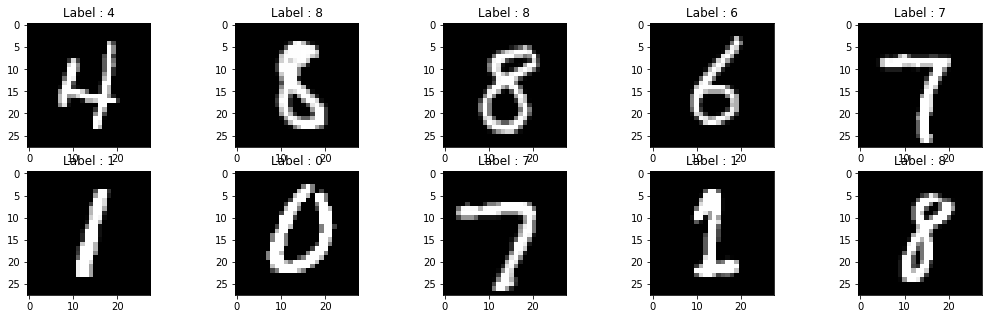

In [3]:
torch.random.manual_seed(1)

compose = transforms.Compose([
                transforms.ToTensor(),
                transforms.ColorJitter(brightness=0.5, contrast=0.2, saturation=0.2, hue=0.2), 
                transforms.Normalize(mean=(0.1307), std=(0.3079)),
            ])

""" 
Brightness merujuk pada kecerahan atau kegelapan keseluruhan gambar. 
Brightness tinggi terlihat lebih terang, 
Brightness rendah terlihat lebih gelap.

Contrast, merujuk pada perbedaan antara area terang dan gelap dalam gambar. 
Kontras tinggi memiliki perbedaan yang lebih besar antara area terang dan gelap, 
Kontras rendah memiliki perbedaan yang lebih kecil.

Hue (warna) adalah istilah yang digunakan untuk menggambarkan warna khusus dalam gambar, 
seperti merah, biru, atau hijau.

Saturation merujuk pada intensitas atau kemurnian warna dalam gambar. 
Gambar dengan saturasi yang tinggi memiliki warna yang lebih hidup dan mencolok, 
sementara gambar yang tidak jenuh memiliki warna yang lebih redup atau pudar.
"""

mnist_train = MNIST(
                root=r'mnist_dataset/train', 
                train=True, 
                transform=compose,
                download=False
            )

mnist_test = MNIST(
                root=r'mnist_dataset/test', 
                train=False, 
                transform=compose,
                download=False
            )

trainloader = DataLoader(mnist_train, batch_size=256, shuffle=True)
testloader = DataLoader(mnist_test, batch_size=256, shuffle=True)

# Todo: get mean and std for normalization
# numbatch = trainloader.__len__()
# mean, std = 0, 0
# for i in trainloader:
#     mean += i[0].mean()
#     std += i[0].std()

# print(mean / numbatch, std / numbatch)

data, label = iter(trainloader).next()
show = 10 # kelipatan 5
ax_idx = 0
fig, ax = plt.subplots(nrows=show//5, ncols=5, figsize=(18, 5))
for i in range(show // 5): 
    for j in range(5):
        ax[i][j].set_title(f"Label : {label[ax_idx]}")
        ax[i][j].imshow(data[ax_idx].permute(1, 2, 0), cmap='gray')
        
        ax_idx += 1

## Tugas 1

In [38]:
class RegularCNN(nn.Module):
    """Some Information about RegualrCNN"""
    def __init__(self, in_channel, out_channel):
        super(RegularCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channel, out_channels=8, kernel_size=3, stride=1, padding='same', bias=False)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3, stride=1, padding='same', bias=False)
        self.conv3 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding='same', bias=False)
        self.conv4 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, stride=1, padding='same', bias=False)
        
        self.bn1 = nn.BatchNorm2d(8)
        self.bn2 = nn.BatchNorm2d(8)
        self.bn3 = nn.BatchNorm2d(16)
        self.bn4 = nn.BatchNorm2d(16)
        
        self.act = nn.LeakyReLU(0.1, inplace=True)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.drop = nn.Dropout(0.2)
        
        self.fc = nn.Linear(in_features=784, out_features=out_channel, bias=True)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.act(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.act(x)
        
        x = self.drop(x)
        x = self.pool(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.act(x)
        
        x = self.conv4(x)
        x = self.bn4(x)
        x = self.act(x)
        
        x = self.drop(x)
        x = self.pool(x)
        
        x = x.flatten(start_dim=1)
        x = self.fc(x)
        
        return x

In [39]:
np.random.seed(1)
torch.random.manual_seed(1)

cnn = RegularCNN(1, 10)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn.parameters(), lr=1e-4)

# loop over the dataset multiple times
device = torch.device('cpu')
max_train_batch = trainloader.__len__()

start = time.time()
epochs = 10
for epoch in range(epochs):
    print(f"Epoch [{epoch+1}/{epochs}]")
    running_loss, running_accuracy = 0.0, 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = cnn(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        with torch.no_grad():
            batch_acc = torch.sum(torch.argmax(outputs, dim=1) == labels) / labels.shape[0]
            running_accuracy += batch_acc.item()
            running_loss += loss.item()
            
            if ((i + 1) % (max_train_batch // 3) == 0) or (i + 1) == max_train_batch:
                print(f"  Batch [{i+1}/{max_train_batch}] Loss : {running_loss / (i+1):.4f} Accuracy : {(running_accuracy / (i + 1)):.4f}")

end = time.time()
print(f'Total training time  [{epochs} epochs : {(end - start):.4f} Second]')

Epoch [1/10]
  Batch [78/235] Loss : 1.8612 Accuracy : 0.4350
  Batch [156/235] Loss : 1.4452 Accuracy : 0.6147
  Batch [234/235] Loss : 1.1753 Accuracy : 0.7039
  Batch [235/235] Loss : 1.1723 Accuracy : 0.7049
Epoch [2/10]
  Batch [78/235] Loss : 0.4531 Accuracy : 0.9110
  Batch [156/235] Loss : 0.4077 Accuracy : 0.9176
  Batch [234/235] Loss : 0.3684 Accuracy : 0.9243
  Batch [235/235] Loss : 0.3678 Accuracy : 0.9244
Epoch [3/10]
  Batch [78/235] Loss : 0.2556 Accuracy : 0.9425
  Batch [156/235] Loss : 0.2375 Accuracy : 0.9465
  Batch [234/235] Loss : 0.2260 Accuracy : 0.9476
  Batch [235/235] Loss : 0.2258 Accuracy : 0.9476
Epoch [4/10]
  Batch [78/235] Loss : 0.1858 Accuracy : 0.9551
  Batch [156/235] Loss : 0.1765 Accuracy : 0.9574
  Batch [234/235] Loss : 0.1694 Accuracy : 0.9586
  Batch [235/235] Loss : 0.1689 Accuracy : 0.9587
Epoch [5/10]
  Batch [78/235] Loss : 0.1450 Accuracy : 0.9635
  Batch [156/235] Loss : 0.1399 Accuracy : 0.9651
  Batch [234/235] Loss : 0.1356 Accuracy

In [29]:
def testModel(loader, model, criterion, device):
    model.eval()
    running_loss = 0.0
    running_accuracy = 0.0
    max_batch = loader.__len__()
    
    with torch.no_grad():
        for i, data in enumerate(loader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # forward only
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            outputs_argmax = torch.argmax(outputs, dim=1)
            running_accuracy += (torch.sum(outputs_argmax ==  labels) / float(outputs.shape[0]))
            
    print(f'Loss: {running_loss / max_batch:.4f} Accuracy : {running_accuracy / max_batch:.4f}')

In [41]:
print(f"Training")
testModel(loader=trainloader, model=cnn, criterion=criterion, device=torch.device('cpu'))
print(f"Testing")
testModel(loader=testloader, model=cnn, criterion=criterion, device=torch.device('cpu'))

Training
Loss: 0.0858 Accuracy : 0.9806
Testing
Loss: 0.0760 Accuracy : 0.9840


In [92]:
# torch.save(cnn.state_dict(), r'SavedModel/RegularCNN_10epoch.pt')

## Tugas 2

## 5 Layer - AlexNet

In [26]:
from torchvision.models.alexnet import AlexNet
torch.random.manual_seed(1)

alexnet = AlexNet()
# Feature Out : [Batch, 192, 2, 2]
# Avgpool Out : [Batch, 192, 6, 6]
alexnet.features = alexnet.features[:5]
alexnet.classifier = nn.Sequential(
                        nn.Flatten(start_dim=1),
                        nn.Linear(in_features=192 * 6 * 6, out_features=32, bias=False), 
                        nn.BatchNorm1d(num_features=32),
                        nn.LeakyReLU(0.1, inplace=True), 
                        nn.Linear(in_features=32, out_features=10),
                    )

for layer in alexnet.parameters():
    layer.requires_grad = True

finetuned_alexnet = nn.Sequential(
                        nn.Conv2d(in_channels=1, out_channels=3, kernel_size=1, stride=1, padding='same'),
                        alexnet
                    )

In [27]:
finetuned_alexnet

Sequential(
  (0): Conv2d(1, 3, kernel_size=(1, 1), stride=(1, 1), padding=same)
  (1): AlexNet(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): ReLU(inplace=True)
    )
    (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
    (classifier): Sequential(
      (0): Flatten(start_dim=1, end_dim=-1)
      (1): Linear(in_features=6912, out_features=32, bias=False)
      (2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): LeakyReLU(negative_slope=0.1, inplace=True)
      (4): Linear(in_features=32, out_features=10, bias=True)
    )
  )
)

In [28]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(finetuned_alexnet.parameters(), lr=1e-4)

# loop over the dataset multiple times
device = torch.device('cpu')
max_train_batch = trainloader.__len__()

start = time.time()
epochs = 10
for epoch in range(epochs):
    print(f"Epoch [{epoch+1}/{epochs}]")
    running_loss, running_accuracy = 0.0, 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = finetuned_alexnet(inputs)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        with torch.no_grad():
            batch_acc = torch.sum(torch.argmax(outputs, dim=1) == labels) / labels.shape[0]
            running_accuracy += batch_acc.item()
            running_loss += loss.item()
            
            if ((i + 1) % (max_train_batch // 3) == 0) or (i + 1) == max_train_batch:
                print(f"  Batch [{i+1}/{max_train_batch}] Loss : {running_loss / (i+1):.4f} Accuracy : {(running_accuracy / (i + 1)):.4f}")

end = time.time()
print(f'Total training time  [{epochs} epochs : {(end - start):.4f} Second]')

Epoch [1/10]
  Batch [78/235] Loss : 1.4243 Accuracy : 0.7705
  Batch [156/235] Loss : 1.2610 Accuracy : 0.8369
  Batch [234/235] Loss : 1.1542 Accuracy : 0.8701
  Batch [235/235] Loss : 1.1530 Accuracy : 0.8704
Epoch [2/10]
  Batch [78/235] Loss : 0.8159 Accuracy : 0.9486
  Batch [156/235] Loss : 0.7660 Accuracy : 0.9530
  Batch [234/235] Loss : 0.7199 Accuracy : 0.9554
  Batch [235/235] Loss : 0.7193 Accuracy : 0.9555
Epoch [3/10]
  Batch [78/235] Loss : 0.5523 Accuracy : 0.9666
  Batch [156/235] Loss : 0.5213 Accuracy : 0.9681
  Batch [234/235] Loss : 0.4927 Accuracy : 0.9696
  Batch [235/235] Loss : 0.4923 Accuracy : 0.9696
Epoch [4/10]
  Batch [78/235] Loss : 0.3920 Accuracy : 0.9740
  Batch [156/235] Loss : 0.3697 Accuracy : 0.9750
  Batch [234/235] Loss : 0.3523 Accuracy : 0.9755
  Batch [235/235] Loss : 0.3522 Accuracy : 0.9755
Epoch [5/10]
  Batch [78/235] Loss : 0.2846 Accuracy : 0.9795
  Batch [156/235] Loss : 0.2721 Accuracy : 0.9795
  Batch [234/235] Loss : 0.2610 Accuracy

In [30]:
print(f"Training")
testModel(loader=trainloader, model=finetuned_alexnet, criterion=criterion, device=torch.device('cpu'))
print(f"Testing")
testModel(loader=testloader, model=finetuned_alexnet, criterion=criterion, device=torch.device('cpu'))

Training
Loss: 0.0791 Accuracy : 0.9929
Testing
Loss: 0.1023 Accuracy : 0.9839


## All Layer - AlexNet

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torchvision.transforms import transforms
import numpy as np 
import matplotlib.pyplot as plt
import time
from torchsummary import summary

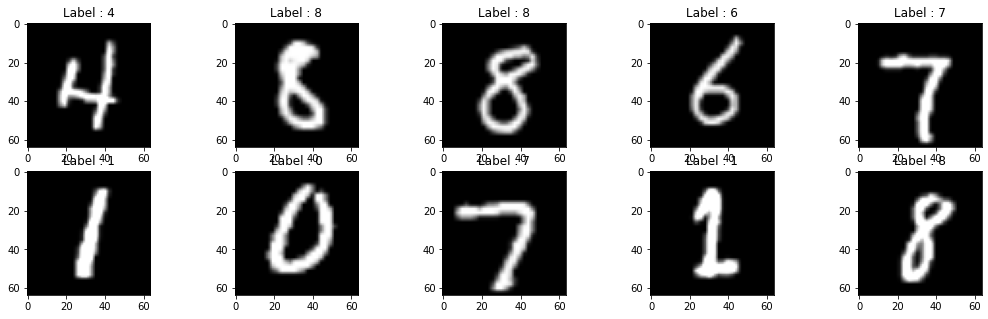

In [2]:
torch.random.manual_seed(1)

compose = transforms.Compose([
                transforms.ToTensor(),
                transforms.Resize((64, 64)),
                transforms.ColorJitter(brightness=0.5, contrast=0.2, saturation=0.2, hue=0.2), 
                transforms.Normalize(mean=(0.1307), std=(0.3079)),
            ])

mnist_train = MNIST(
                root=r'mnist_dataset/train', 
                train=True, 
                transform=compose,
                download=False
            )

mnist_test = MNIST(
                root=r'mnist_dataset/test', 
                train=False, 
                transform=compose,
                download=False
            )

trainloader = DataLoader(mnist_train, batch_size=64, shuffle=True)
testloader = DataLoader(mnist_test, batch_size=64, shuffle=True)

# Todo: get mean and std for normalization

data, label = iter(trainloader).next()
show = 10 # kelipatan 5
ax_idx = 0
fig, ax = plt.subplots(nrows=show//5, ncols=5, figsize=(18, 5))
for i in range(show // 5): 
    for j in range(5):
        ax[i][j].set_title(f"Label : {label[ax_idx]}")
        ax[i][j].imshow(data[ax_idx].permute(1, 2, 0), cmap='gray')
        
        ax_idx += 1

In [3]:
from torchvision.models.alexnet import AlexNet
torch.random.manual_seed(1)

alexnet_full = AlexNet()

for layer in alexnet_full.parameters():
    layer.requires_grad = False
    
alexnet_full.features = alexnet_full.features
alexnet_full.classifier = nn.Sequential(
                            nn.Flatten(start_dim=1),
                            nn.Dropout(0.2),
                            nn.Linear(in_features=256 * 6 * 6, out_features=16, bias=False), 
                            nn.BatchNorm1d(num_features=16),
                            nn.LeakyReLU(0.1, inplace=True), 
                            nn.Linear(in_features=16, out_features=10),
                        )

alexnet_2 = nn.Sequential(
                nn.Conv2d(in_channels=1, out_channels=3, kernel_size=1, stride=1, padding='same'),
                alexnet_full
            )

for layer in alexnet_2.parameters():
    print(layer.requires_grad)

True
True
False
False
False
False
False
False
False
False
False
False
True
True
True
True
True


In [13]:
summary(alexnet_2, input_size=(1, 64, 64), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 3, 64, 64]               6
            Conv2d-2           [-1, 64, 15, 15]          23,296
              ReLU-3           [-1, 64, 15, 15]               0
         MaxPool2d-4             [-1, 64, 7, 7]               0
            Conv2d-5            [-1, 192, 7, 7]         307,392
              ReLU-6            [-1, 192, 7, 7]               0
         MaxPool2d-7            [-1, 192, 3, 3]               0
            Conv2d-8            [-1, 384, 3, 3]         663,936
              ReLU-9            [-1, 384, 3, 3]               0
           Conv2d-10            [-1, 256, 3, 3]         884,992
             ReLU-11            [-1, 256, 3, 3]               0
           Conv2d-12            [-1, 256, 3, 3]         590,080
             ReLU-13            [-1, 256, 3, 3]               0
        MaxPool2d-14            [-1, 25

In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(alexnet_2.parameters(), lr=1e-4)

# loop over the dataset multiple times
device = torch.device('cpu')
max_train_batch = trainloader.__len__()
print(f'Total batch : {max_train_batch}')
start = time.time()
epochs = 5
for epoch in range(epochs):
    print(f"Epoch [{epoch+1}/{epochs}]")
    running_loss, running_accuracy = 0.0, 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = alexnet_2(inputs)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        with torch.no_grad():
            batch_acc = torch.sum(torch.argmax(outputs, dim=1) == labels) / labels.shape[0]
            running_accuracy += batch_acc.item()
            running_loss += loss.item()
            
            if ((i + 1) % (max_train_batch // 3) == 0) or (i + 1) == max_train_batch:
                print(f"  Batch [{i+1}/{max_train_batch}] Loss : {running_loss / (i+1):.4f} Accuracy : {(running_accuracy / (i + 1)):.4f}")

end = time.time()
print(f'Total training time  [{epochs} epochs : {(end - start):.4f} Second]')

Total batch : 938
Epoch [1/5]
  Batch [312/938] Loss : 1.8020 Accuracy : 0.5017
  Batch [624/938] Loss : 1.6491 Accuracy : 0.6037
  Batch [936/938] Loss : 1.5367 Accuracy : 0.6596
  Batch [938/938] Loss : 1.5360 Accuracy : 0.6599
Epoch [2/5]
  Batch [312/938] Loss : 1.1527 Accuracy : 0.8066
  Batch [624/938] Loss : 1.0891 Accuracy : 0.8150
  Batch [936/938] Loss : 1.0294 Accuracy : 0.8248
  Batch [938/938] Loss : 1.0290 Accuracy : 0.8251
Epoch [3/5]
  Batch [312/938] Loss : 0.8164 Accuracy : 0.8541
  Batch [624/938] Loss : 0.7809 Accuracy : 0.8577
  Batch [936/938] Loss : 0.7470 Accuracy : 0.8616
  Batch [938/938] Loss : 0.7468 Accuracy : 0.8616
Epoch [4/5]
  Batch [312/938] Loss : 0.6264 Accuracy : 0.8726
  Batch [624/938] Loss : 0.5978 Accuracy : 0.8772
  Batch [936/938] Loss : 0.5759 Accuracy : 0.8797
  Batch [938/938] Loss : 0.5758 Accuracy : 0.8796
Epoch [5/5]
  Batch [312/938] Loss : 0.4974 Accuracy : 0.8878
  Batch [624/938] Loss : 0.4858 Accuracy : 0.8885
  Batch [936/938] Loss